In [1]:
from modules.retrieve_votes_data import Votes
import pandas as pd
import numpy as np
from nltk import agreement

VOTES_DATA_FILE_NAME = 'data/05-03-2022_votes_per_user.csv'
LABELED_DATA_FILE_NAME = 'data/05-03-2022_labeled_comments.csv'

In [2]:
# load votes per user data to pandas dataframe
votes_per_user = pd.read_csv(VOTES_DATA_FILE_NAME, sep=';')

In [3]:
# get only comments that have been voted by 4 users with equal gender distirbution
vote_count = votes_per_user.groupby(['comment_id']).agg(['count'])
comment_ids = list(vote_count['user_id'][vote_count['user_id']['count'] == 4].index)

female_vote_count = votes_per_user[votes_per_user['gender']=='fem'].groupby(['comment_id']).agg(['count'])
female_comment_ids = list(female_vote_count['user_id'][female_vote_count['user_id']['count'] == 2].index)
male_vote_count = votes_per_user[votes_per_user['gender']=='masc'].groupby(['comment_id']).agg(['count'])
male_comment_ids = list(male_vote_count['user_id'][male_vote_count['user_id']['count'] == 2].index)

equal_comments = []
for id in comment_ids:
    if id in female_comment_ids and id in male_comment_ids:
        equal_comments.append(id)

In [4]:
def kappa_agreement(comment_ids, dataframe, comment_vote):
    # generates a votes X user dataframe to each comment found
    for comment in comment_ids:
        df = dataframe[(dataframe['comment_id']== comment)]
        keys = list(comment_vote.keys())

        for i in range(0, len(keys)):
            if keys[i] == 'comment_id':
                comment_vote['comment_id'].append(comment)
            else:
                comment_vote[keys[i]].append(df.iloc[i-1].vote)
    comment_vote = pd.DataFrame(comment_vote)

    # calculates kappa value to voted comments

    keys = list(comment_vote.keys())
    coders = {}
    for i in range(1, len(keys)):
        coders[i] = list(comment_vote[keys[i]])

    formatted_codes = []
    for key in list(coders.keys()):
        formatted_codes = formatted_codes + [[key,i,coders[key][i]] for i in range(len(coders[key]))]

    ratingtask = agreement.AnnotationTask(data=formatted_codes)

    return ratingtask.multi_kappa()

In [5]:
# Kappa to equally voted comments using 2x2 gender distribution
comment_vote_eq = {
    'comment_id': [],
    'user_A': [],
    'user_B': [],
    'user_C': [],
    'user_D': [],
}
kappa_agreement(equal_comments, votes_per_user, comment_vote_eq)

0.4256501664871821

In [6]:
df = votes_per_user[votes_per_user['comment_id'].isin(equal_comments)]

In [7]:
# female agreement
comment_vote_fem = {
    'comment_id': [],
    'user_A': [],
    'user_B': [],
}
female_votes_per_user = df[df['gender']=='fem']
kappa_agreement(equal_comments, female_votes_per_user, comment_vote_fem)

0.5123489227535468

In [8]:
# male agreement
comment_vote_masc = {
    'comment_id': [],
    'user_A': [],
    'user_B': [],
}
male_votes_per_user = df[df['gender']=='masc']
kappa_agreement(equal_comments, male_votes_per_user, comment_vote_fem)

0.43958228812457034

---

In [9]:
labeled = pd.read_csv(LABELED_DATA_FILE_NAME, sep=';')
female_votes_per_user = votes_per_user[votes_per_user['gender']=='fem']
male_votes_per_user = votes_per_user[votes_per_user['gender']=='masc']

In [10]:
def should_be_selected(comment_id):
    selected = votes_per_user[votes_per_user['comment_id']==comment_id]
    count_fem = len(selected[selected['gender']=='fem'])
    count_masc = len(selected[selected['gender']=='masc'])
    label = labeled[labeled['comment_id']==comment_id]
    ## this condition removes the not labeled comments to each gender
    #if float(label['fem_avg']) == 0 and float(label['masc_avg']) == 0:
    #    return False
    if count_fem >= 2 and count_masc >=2:
        return True
    return False

def calculate_fem_norm_avg(comment_id):
    selected = female_votes_per_user[female_votes_per_user['comment_id']==comment_id]
    return np.average(list(selected['vote']))*2-1

def calculate_masc_norm_avg(comment_id):
    selected = male_votes_per_user[male_votes_per_user['comment_id']==comment_id]
    return np.average(list(selected['vote']))*2-1

In [11]:
labeled['fem_avg'] = labeled['comment_id'].apply(calculate_fem_norm_avg)
labeled['masc_avg'] = labeled['comment_id'].apply(calculate_masc_norm_avg)
labeled['selected'] = labeled.comment_id.apply(should_be_selected)
labeled = labeled[labeled['selected']==True]

/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)


In [12]:
Y = list(labeled['fem_avg'])
X = list(labeled['masc_avg'])

In [41]:
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt

def scatter_plot(X,Y):
    font = {'fontname':'Helvetica'}
    colors = [np.random.rand(len(X))]
    sizes = np.array([i for i in range(0,len(Y))])
    fig, ax = plt.subplots(figsize=(6, 6))
    area = (60 * np.random.rand(len(Y)))**2  # 0 to 15 point radii

    plt.tight_layout()
    plt.scatter(X, Y, s=area, alpha=0.15, c=cm.PuRd(range(370)))
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    plt.xlabel("Homens", **font)
    plt.ylabel("Mulheres", **font)
    plt.show()

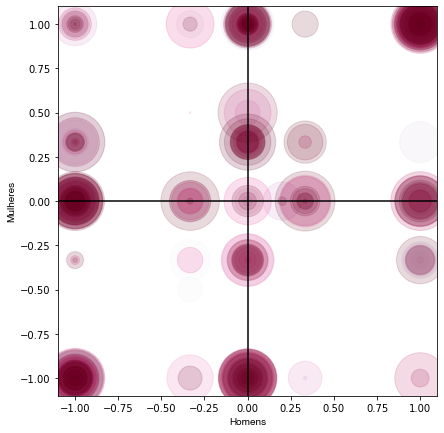

In [42]:
scatter_plot(X,Y)

---

In [31]:
def fem_prevalence(comment_id):
    selected=votes_per_user[votes_per_user['comment_id']==comment_id]
    selected=selected[selected['gender']=='fem']
    count_sexist = len(selected[selected['vote']==1])
    return (count_sexist/len(selected)*2)-1

def masc_prevalence(comment_id):
    selected=votes_per_user[votes_per_user['comment_id']==comment_id]
    selected=selected[selected['gender']=='masc']
    count_sexist = len(selected[selected['vote']==1])
    return (count_sexist/len(selected)*2)-1

In [32]:
labeled['fem_prevalence'] = labeled.comment_id.apply(fem_prevalence)
labeled['masc_prevalence'] = labeled.comment_id.apply(masc_prevalence)

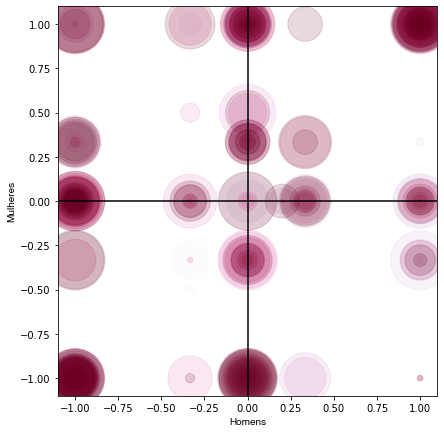

In [43]:
Y = list(labeled['fem_prevalence'])
X = list(labeled['masc_prevalence'])
scatter_plot(X,Y)